# Quora question pair similarity

### Problem description

Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers.Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term. 
*Source*: https://www.kaggle.com/c/quora-question-pairs/overview

### Problem statement 



*   Given a question identify whether the question has already been asked. If yes, we  can provide instant answers to the questions already asked. 



### Translating the problem into machine learning terms



*   Build a classification model to predict if a question is duplicate or not.
*   Currently Quora uses random forest model. Use advanced technique for better performance.
*   The ground truth labels on this dataset should be taken to be 'informed' but not 100% accurate, and may include incorrect labeling. Thus it would be better if our model can output the probability of each class. 
*   There is no strict latency requirement. 
*   True positve (considering real duplicate) is important. Cost of misclassification as false positive (considering a non duplicate as a duplicate) is very high.
*   Model may not be interpretable. i.e., model need not show us why is it considering a question as a duplicate or not.







https://www.kaggle.com/davidthaler/duplicates-of-duplicates


## Data Overview

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
#import distance
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

In [1]:
import pandas as pd
df=pd.read_csv('train.csv')

In [3]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0


There are 5 columns:
qid1, qid2 (IDs of questions)
question1, question2 (questions)
is_duplicate (Target value- Binary) which describes whether the questions 1 and 2 are duplicate

In [4]:
df.shape

(404290, 6)

In [6]:
df.columns

Index(['qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [5]:
df.drop('id',axis=1,inplace=True)

There are 40,4290 records and 5 columns

**Train test split**

Text(0, 0.5, 'Number of records')

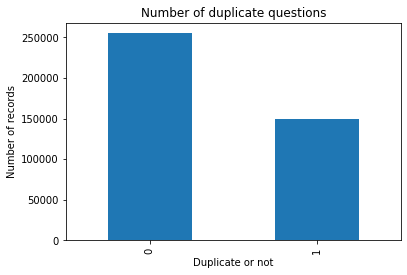

In [5]:
dupliate=df['is_duplicate'].value_counts()
p1 = dupliate.plot(kind='bar', title='Number of duplicate questions')#,x='Number of records')
p1.set_xlabel("Duplicate or not")
p1.set_ylabel("Number of records")

In [0]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


In [0]:
df['qid1'].nunique()

290654

In [0]:
df['qid2'].nunique()

299364

This means that q1 and q2 is repeated almost 11,000 times

In [0]:
import numpy as np
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



Majority of questions occurs only once.

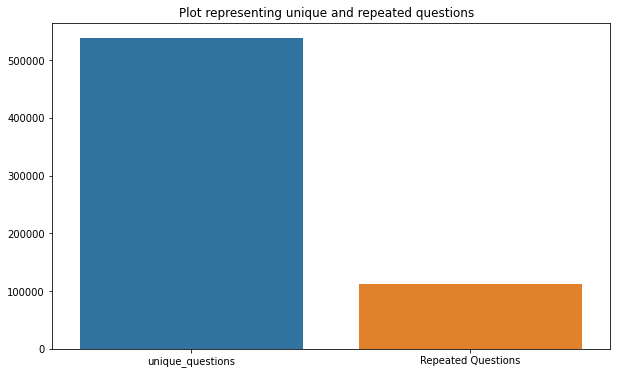

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

Check whether there are any repeated pair of questions

In [0]:
df1=df.duplicated(['qid1','qid2'],keep=False)

In [0]:
df1.shape[0]-df.shape[0]

0

There are not duplicate pair of questions (duplicate rows)

In [7]:
df[df.isnull().any(1)]

,qid1,qid2,question1,question2,is_duplicate
105780,174363,174364,How can I develop android app?,NaN,0
201841,303951,174364,How can I create an Android app?,NaN,0
363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


There are three rows which has null values in questions. All the three are marked as non duplicates. Since there are just three rows, we can delete those rows. 

In [8]:
df.dropna(axis=0,how='any',inplace=True)

## Feature engineering/ Feature extraction

Some features that we can consider before cleaning:
1. Number of times question 1 and question 2 occurs
2. Number of words in question 1 and 2
3. Number of unique words common in question 1 and 2
4. Length of questions in 1 and 2.

Note: before checking number of unique words common in question 1 and 2 we have to do basic preprocessing of deleting stopwords and correcting spelling mistakes etc.

Number of times question 1 and question 2 occurs 

In [9]:
"freq_q1= Number of times question 1 occues (Frequency of question 1)"
df['freq_q1'] = df.groupby('qid1')['qid1'].transform('count') 
df['freq_q2'] = df.groupby('qid2')['qid2'].transform('count') 

Number of words in question 1 and 2

In [10]:
#will get error : 'float' object has no attribute 'split'because of Nan Values in question1. Filter out those values before performing the operation
df['q1_nwords'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_nwords'] = df['question2'].apply(lambda row: len(row.split(" ")))

Number of unique words common in question 1 and 2

Doing basic preprocessing of replacing short forms and correcting spellings.

In [11]:
#function to correct sentences
def correctwords(mispelled_question:str):
  from spellchecker import SpellChecker
  spell=SpellChecker()
  correct={}
#find those words that may be misspelled
  misspelled=spell.unknown(mispelled_question.lower().split(" "))
  #print(misspelled)
  for word in misspelled:
    correct[word]=spell.correction(word)
  corrected_sent = ' '.join([correct.get(i, i) for i in mispelled_question.lower().split(" ")])
  return corrected_sent


In [12]:
import re
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    #will replace even 9000000 as 1m
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    return x
df["question1"] = df["question1"].fillna("").apply(preprocess)
df["question2"] = df["question2"].fillna("").apply(preprocess)

*   Number of unique stop words common in both questions






In [13]:
import nltk
nltk.download('stopwords')
import re
from nltk.corpus import stopwords
STOP_WORDS = stopwords.words("english")
def commonwords(q1,q2):
  q1tokens = q1.split()
  q2tokens = q2.split()
  q1words = set([word for word in q1tokens if word not in STOP_WORDS])
  q2words = set([word for word in q2tokens if word not in STOP_WORDS])
  common_word_count = len(q1words.intersection(q2words))
  return common_word_count
df['common_word_count'] = df.apply(lambda x: commonwords(x["question1"], x["question2"]), axis=1)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\12034\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [14]:
def commonstopwords(q1,q2):
   q1tokens = q1.split()
   q2tokens = q2.split()
   q1stops = set([word for word in q1tokens if word in STOP_WORDS])
   q2stops = set([word for word in q2tokens if word in STOP_WORDS])
   common_stop_count=len(q1stops.intersection(q1stops))
   return common_stop_count
df['common_stop_count'] = df.apply(lambda x: commonstopwords(x["question1"], x["question2"]), axis=1)

In [15]:
df.head(2)

,qid1,qid2,question1,question2,is_duplicate,freq_q1,freq_q2,q1_nwords,q2_nwords,common_word_count,common_stop_count
0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,14,12,4,6
1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,4,1,8,13,2,4


In [17]:
df['diff_between_nwords']=abs(df['q1_nwords']-df['q2_nwords'])

In [18]:
print ("Minimum length of the questions in question1 : " , min(df['q1_nwords']))

print ("Minimum length of the questions in question2 : " , min(df['q2_nwords']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_nwords']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_nwords']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 66
Number of Questions with minimum length [question2] : 22


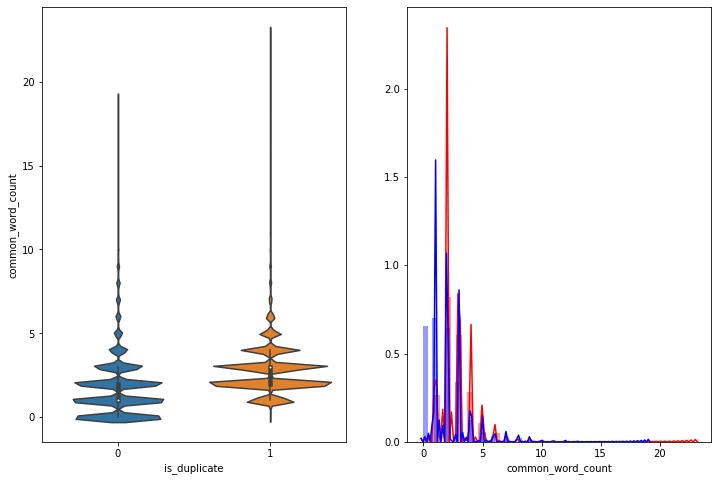

In [23]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'common_word_count', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['common_word_count'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['common_word_count'][0:] , label = "0" , color = 'blue' )
plt.show()

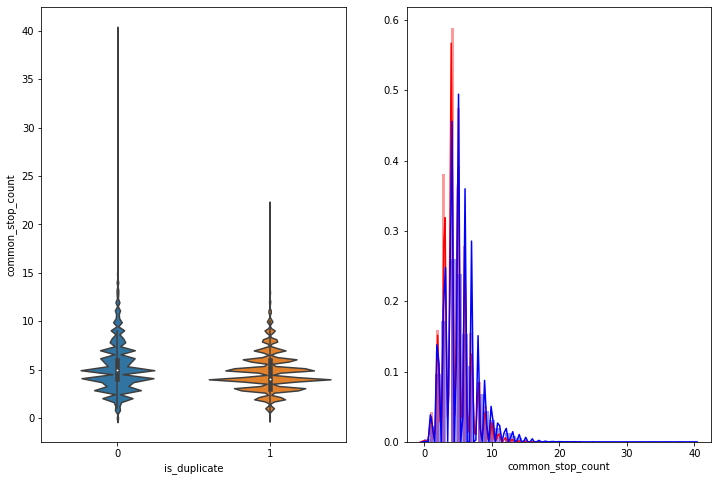

In [24]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'common_stop_count', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['common_stop_count'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['common_stop_count'][0:] , label = "0" , color = 'blue' )
plt.show()

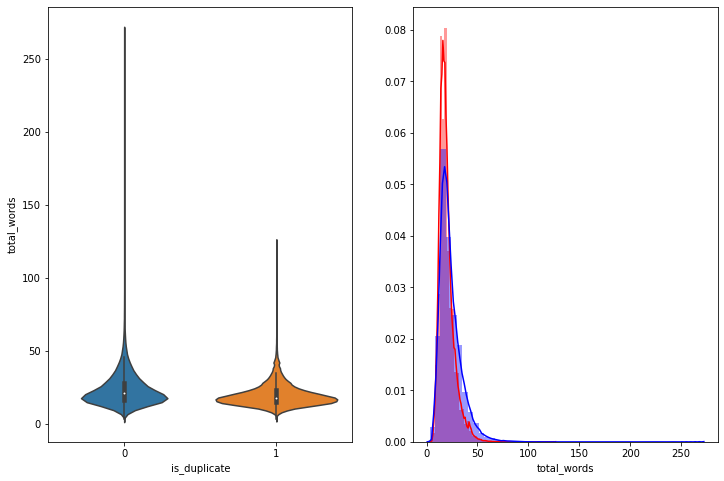

In [25]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'total_words', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['total_words'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['total_words'][0:] , label = "0" , color = 'blue' )
plt.show()

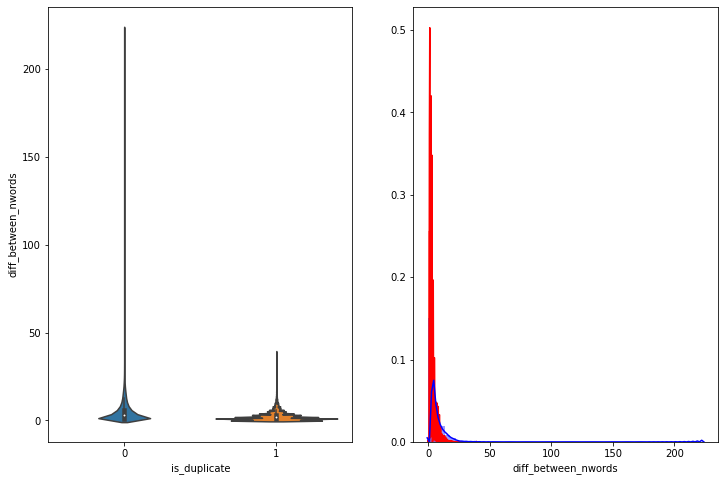

In [26]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'diff_between_nwords', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['diff_between_nwords'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['diff_between_nwords'][0:] , label = "0" , color = 'blue' )
plt.show()

These graphs shows that the extracted features are not good enough for classifying duplicate questions since the two classes are highly overlapping. Hence we have to extract more useful features.

One thing we can check is how does %age of words shared by two questions differ between duplicate and non duplicate questions?

In [19]:
def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
df['total_words'] = df.apply(normalized_word_Total, axis=1)

In [20]:
df['wordshare']=(df['common_word_count']+df['common_stop_count'])/df['total_words']

In [29]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_q1,freq_q2,q1_nwords,q2_nwords,common_word_count,common_stop_count,total_words,diff_between_nwords,wordshare
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,14,12,4,6,23.0,2,0.434783
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,4,1,8,13,2,4,20.0,5,0.300000


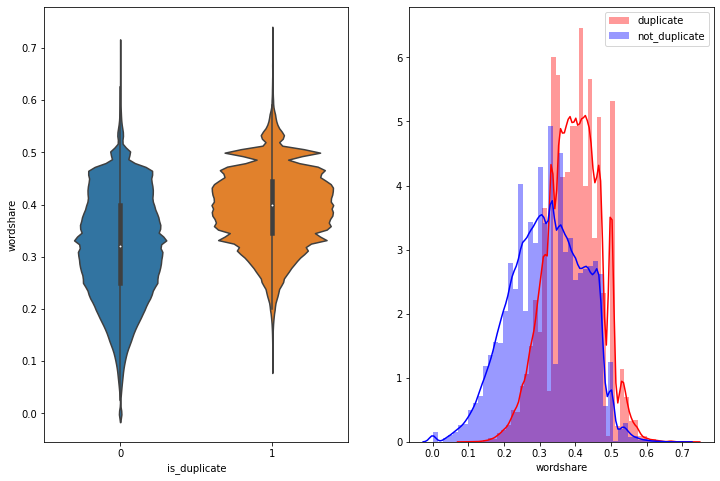

In [30]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'wordshare', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['wordshare'][0:] , label = "duplicate", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['wordshare'][0:] , label = "not_duplicate" , color = 'blue' )
plt.legend()
plt.show()

The feature wordshare is helpful in differentiating between duplicate and non duplicate questions

**Features to extract the similarity of two questions.**

It is quite obvious that if two questions are considered duplicate that means the two questions are almost similar. Hence features which can extract how much similar are the two questions can help our model. For this purpose we can use fuzzywuzzy model which can return the similarity index of two strings.
https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
We can use fuzzy ratio and fuzzy partial ratio.

Preprocessing before the operation:


In [21]:
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
def preprocessing(x):
    porter = PorterStemmer()
    pattern = re.compile('\W')
    #removes special character
    if type(x) == type(''):
      x = re.sub(pattern, ' ', x)
    if type(x) == type(''):
      x = porter.stem(x)
      example1 = BeautifulSoup(x)
      x = example1.get_text()
    return x
df["question1"] = df["question1"].fillna("").apply(preprocessing)
df["question2"] = df["question2"].fillna("").apply(preprocessing)

In [24]:
df.head(2)

,qid1,qid2,question1,question2,is_duplicate,freq_q1,freq_q2,q1_nwords,q2_nwords,common_word_count,common_stop_count,total_words,diff_between_nwords,wordshare
0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,14,12,4,6,23.0,2,0.434783
1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,8,13,2,4,20.0,5,0.300000


In [22]:
def stopword_removal(question):
  qtokens = question.split()
  qwords = set([word for word in qtokens if word not in STOP_WORDS])
  return (" ").join(qwords)

In [23]:
df['question1']=df['question1'].apply(stopword_removal)
df['question2']=df['question2'].apply(stopword_removal)

In [35]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_q1,freq_q2,q1_nwords,q2_nwords,common_word_count,common_stop_count,total_words,diff_between_nwords,wordshare
0,0,1,2,step invest guide market share india,step invest guide market share,0,1,1,14,12,4,6,23.0,2,0.434783
1,1,3,4,story koh noor diamond kohinoor,happen government koh indian stole would noor ...,0,4,1,8,13,2,4,20.0,5,0.300000


In [24]:
from fuzzywuzzy import fuzz 
from fuzzywuzzy import process 
df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1) #Computes full match
df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1) #Computes match for almost similar string
df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1) #accounts for reorderd strings
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1) #account for duplicate words as well

C:\Users\12034\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



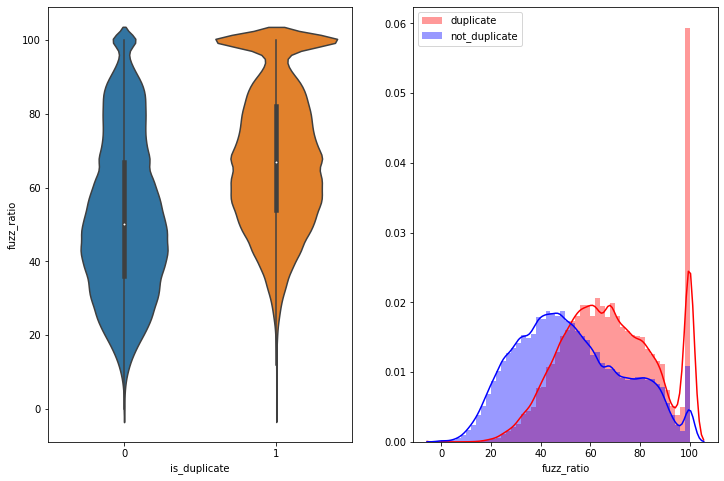

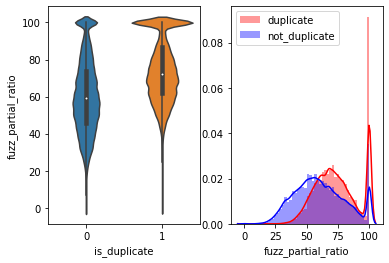

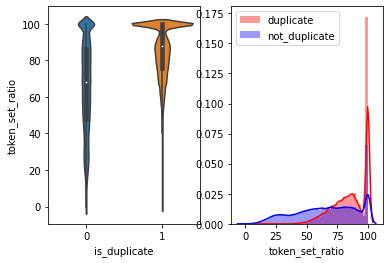

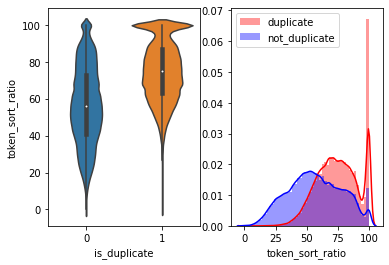

In [0]:
featurelst=['fuzz_ratio','fuzz_partial_ratio','token_set_ratio','token_sort_ratio']
plt.figure(figsize=(12, 8))
for i in featurelst:
    plt.subplot(1,2,1)
    sns.violinplot(x = 'is_duplicate', y = i, data = df[0:])

    plt.subplot(1,2,2)
    sns.distplot(df[df['is_duplicate'] == 1.0][i][0:] , label = "duplicate", color = 'red')
    sns.distplot(df[df['is_duplicate'] == 0.0][i][0:] , label = "not_duplicate" , color = 'blue' )
    plt.legend()
    plt.show()

All the four features can be thought as a useful feature since the graphs are not completely overlapping.

Check if last word or first word of two questions are equal and how they differ between duplicate and non duplicate questions 

In [0]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_q1,freq_q2,q1_nwords,q2_nwords,common_word_count,common_stop_count,diff_between_nwords,total_words,wordshare
0,0,1,2,invest guide india step market share,invest guide step market share,0,1,1,14,12,4,6,2,23.0,0.434783
1,1,3,4,story koh kohinoor diamond noor,noor happen koh kohinoor diamond would indian ...,0,4,1,8,13,2,4,5,20.0,0.300000


In [25]:
    # Last word of both question is same or not
def tokenize_extractWords(q1,q2):
  q1_tokens=q1.split(' ')
  q2_tokens=q2.split(' ')
  last_word_common = int(q1_tokens[-1] == q2_tokens[-1])
  first_word_common = int(q1_tokens[0] == q2_tokens[0])
  return last_word_common,first_word_common
common_flags=df.apply(lambda x: tokenize_extractWords(x["question1"], x["question2"]), axis=1)

In [26]:
df['last_word_commonFlag']=list(map(lambda x: x[0], common_flags))
df['first_word_commonFlag']=list(map(lambda x: x[1], common_flags))

In [27]:
df.head(2)

,qid1,qid2,question1,question2,is_duplicate,freq_q1,freq_q2,q1_nwords,q2_nwords,common_word_count,common_stop_count,total_words,diff_between_nwords,wordshare,fuzz_ratio,fuzz_partial_ratio,token_set_ratio,token_sort_ratio,last_word_commonFlag,first_word_commonFlag
0,1,2,share step guide invest india market,share step guide invest market,0,1,1,14,12,4,6,23.0,2,0.434783,91,83,100,91,1,1
1,3,4,kohinoor story koh noor diamond,indian koh happen back noor government kohinoo...,0,4,1,8,13,2,4,20.0,5,0.300000,37,61,89,59,0,0


Also, since the feature wordshare is considered useful we can extract other features related to wordshare such as : minimum wordshare ration, maximum wordshare ratio etc. Some of them are listed below:


Ratio of common_word_count to min lenghth of word count of Q1 and Q2

In [29]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 
df['cwc_min']= df['common_word_count'] / (min(len(df['q1_nwords']), len(df['q2_nwords'])) + SAFE_DIV)

Ratio of common_word_count to max lenghth of word count of Q1 and Q2

In [31]:
df['cwc_max']= df['common_word_count'] / (min(len(df['q1_nwords']), len(df['q2_nwords'])) + SAFE_DIV)

Ratio of common_stop_count to min lenghth of token count of Q1 and Q2

In [33]:
df['cws_min']= df['common_stop_count'] / (min(len(df['q1_nwords']), len(df['q2_nwords'])) + SAFE_DIV)

Ratio of common_stop_count to max lenghth of token count of Q1 and Q2

In [34]:
df['cws_max']= df['common_stop_count'] / (max(len(df['q1_nwords']), len(df['q2_nwords'])) + SAFE_DIV)

Wordcloud of duplicate and non duplicate questions

In [0]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

In [0]:
text=" ".join(question for question in df_duplicate.question1)

In [0]:
text2=" ".join(question for question in df_duplicate.question2)

In [0]:
questions=text+text2

In [49]:
type(questions)

str

In [0]:
text1=" ".join(question for question in dfp_nonduplicate.question1)
text21=" ".join(question for question in dfp_nonduplicate.question2)
questions_nondup=text1+text2

Word Cloud for Duplicate Question pairs


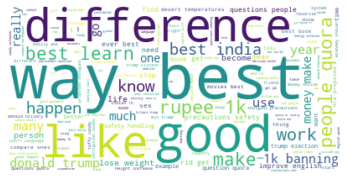

In [52]:
from wordcloud import WordCloud 
wc = WordCloud(background_color="white", max_words=len(questions), stopwords=STOP_WORDS)
wc.generate(questions)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for non Duplicate Question pairs


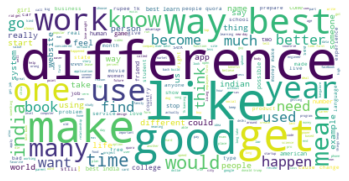

In [53]:
wc = WordCloud(background_color="white", max_words=len(questions_nondup), stopwords=STOP_WORDS)
wc.generate(questions_nondup)
print ("Word Cloud for non Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Some words occur more often in class 1 than class 0. This shows that number of times a word occurs(BOW,TFIDF) type of features might be useful for classification task

In [35]:
df.head(2)

,qid1,qid2,question1,question2,is_duplicate,freq_q1,freq_q2,q1_nwords,q2_nwords,common_word_count,...,fuzz_ratio,fuzz_partial_ratio,token_set_ratio,token_sort_ratio,last_word_commonFlag,first_word_commonFlag,cwc_min,cwc_max,cws_min,cws_max
0,1,2,share step guide invest india market,share step guide invest market,0,1,1,14,12,4,...,91,83,100,91,1,1,0.000010,0.000010,0.000015,0.000015
1,3,4,kohinoor story koh noor diamond,indian koh happen back noor government kohinoo...,0,4,1,8,13,2,...,37,61,89,59,0,0,0.000005,0.000005,0.000010,0.000010


### Train test split

In [36]:
y = df['is_duplicate'].values
X = df.drop(['is_duplicate'], axis=1)
X.head(1)

,qid1,qid2,question1,question2,freq_q1,freq_q2,q1_nwords,q2_nwords,common_word_count,common_stop_count,...,fuzz_ratio,fuzz_partial_ratio,token_set_ratio,token_sort_ratio,last_word_commonFlag,first_word_commonFlag,cwc_min,cwc_max,cws_min,cws_max
0,1,2,share step guide invest india market,share step guide invest market,1,1,14,12,4,6,...,91,83,100,91,1,1,0.00001,0.00001,0.000015,0.000015


In [37]:
X.shape

(404287, 23)

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y,random_state=0)

In [39]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (270872, 23)
Number of data points in test data : (133415, 23)


In [51]:
import pickle
pickle.dump(X_train, open("XTrain_quora.pkl", "wb"))
pickle.dump(y_train, open("ytrain_quora.pkl", "wb"))
pickle.dump(y_test, open("ytest_quora.pkl", "wb"))
pickle.dump(X_test, open("X_test_quora.pkl", "wb"))

In [61]:
import pickle
pickle_in=open("XTrain_quora.pkl","rb")
XTrain=pickle.load(pickle_in)
pickle_in=open("ytest_quora.pkl","rb")
y_test=pickle.load(pickle_in)
pickle_in=open("ytrain_quora.pkl","rb")
ytrain=pickle.load(pickle_in)
pickle_in=open("X_test_quora.pkl","rb")
X_test=pickle.load(pickle_in)

In [40]:
from collections import Counter
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6307997873534363 Class 1:  0.36920021264656366
---------- Distribution of output variable in train data ----------
Class 0:  0.36920136416444926 Class 1:  0.36920136416444926


In [43]:
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import sys
import os 
from tqdm import tqdm
import spacy

### Vectorizing the questions

In [20]:
len(total_num_words)

232676

In [16]:
total_num_words

2662666

There are 2 million words amongst which there are 23k unique words.

In [63]:
tfidf_vect = TfidfVectorizer(analyzer='word', ngram_range=(1,3), max_features=5000)
tfidf_vect.fit(pd.concat((XTrain['question1'],XTrain['question2'])).unique())
trainq1_trans = tfidf_vect.transform(XTrain['question1'].values)
trainq2_trans = tfidf_vect.transform(XTrain['question2'].values)
testq1_trans = tfidf_vect.transform(X_test['question1'].values)
test2_trans = tfidf_vect.transform(X_test['question2'].values)

In [65]:
from scipy.sparse import hstack


In [77]:
f1=XTrain['freq_q1'].values.reshape(-1,1)
f2=XTrain['freq_q2'].values.reshape(-1,1)
f3=XTrain['q1_nwords'].values.reshape(-1,1)
f4=XTrain['q2_nwords'].values.reshape(-1,1)
f5=XTrain['common_word_count'].values.reshape(-1,1)
f6=XTrain['common_stop_count'].values.reshape(-1,1)
f7=XTrain['total_words'].values.reshape(-1,1)
f8=XTrain['diff_between_nwords'].values.reshape(-1,1)
f9=XTrain['wordshare'].values.reshape(-1,1)
f10=XTrain['fuzz_ratio'].values.reshape(-1,1)
f11=XTrain['fuzz_partial_ratio'].values.reshape(-1,1)
f12=XTrain['token_set_ratio'].values.reshape(-1,1)
f13=XTrain['token_sort_ratio'].values.reshape(-1,1)
f14=XTrain['last_word_commonFlag'].values.reshape(-1,1)
f15=XTrain['first_word_commonFlag'].values.reshape(-1,1)
f16=XTrain['cwc_min'].values.reshape(-1,1)
f17=XTrain['cwc_max'].values.reshape(-1,1)
f18=XTrain['cws_min'].values.reshape(-1,1)
f19=XTrain['cws_max'].values.reshape(-1,1)


In [81]:
f1=X_test['freq_q1'].values.reshape(-1,1)
f2=X_test['freq_q2'].values.reshape(-1,1)
f3=X_test['q1_nwords'].values.reshape(-1,1)
f4=X_test['q2_nwords'].values.reshape(-1,1)
f5=X_test['common_word_count'].values.reshape(-1,1)
f6=X_test['common_stop_count'].values.reshape(-1,1)
f7=X_test['total_words'].values.reshape(-1,1)
f8=X_test['diff_between_nwords'].values.reshape(-1,1)
f9=X_test['wordshare'].values.reshape(-1,1)
f10=X_test['fuzz_ratio'].values.reshape(-1,1)
f11=X_test['fuzz_partial_ratio'].values.reshape(-1,1)
f12=X_test['token_set_ratio'].values.reshape(-1,1)
f13=X_test['token_sort_ratio'].values.reshape(-1,1)
f14=X_test['last_word_commonFlag'].values.reshape(-1,1)
f15=X_test['first_word_commonFlag'].values.reshape(-1,1)
f16=X_test['cwc_min'].values.reshape(-1,1)
f17=X_test['cwc_max'].values.reshape(-1,1)
f18=X_test['cws_min'].values.reshape(-1,1)
f19=X_test['cws_max'].values.reshape(-1,1)


In [79]:
X_train=hstack((trainq1_trans,trainq2_trans,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19)).tocsr()

In [83]:
X_test=hstack((testq1_trans,test2_trans,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19)).tocsr()

In [80]:
X_train.shape

(270872, 10019)

In [84]:
X_test.shape

(133415, 10019)

In [85]:
from scipy import sparse
sparse.save_npz("XTrain.npz", X_train)
sparse.save_npz("XTest.npz", X_test)

In [2]:
from scipy import sparse
#X_tr = sparse.load_npz("X_tr.npz")
Q_vec_train=sparse.load_npz("Q_vec_train.npz")
Q_vec_test=sparse.load_npz("Q_vec_test.npz")

In [35]:
print("After vectorizations")
print(question_vectors_train.shape, question_vectors_test.shape)

After vectorizations
(541744, 15000) (266830, 15000)


This is a high dimensional data. Thus we can use Logistic regression, Linear SVM and XGBoost to model this. These are the models that work best in high dimensional data. Other classifcation model includes Decision tree, Ensemble models and KNN. These will not work well on high dimensional data. Hence these models will not be used.